In [1]:
import numpy as np
import math as ma
import joblib 
import matplotlib as mpl

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import IPython
import math
import os

import torch.nn.functional as F
from torch import optim
import random

from tqdm import tqdm

In [2]:
length_of_dataset = 2500

adv_fea = open('./logits/adv_3','r')
adv_fea = adv_fea.read()
adv_fea = adv_fea.replace('\n', ',').split(',')
adv_fea = np.array(adv_fea).reshape((-1,10)).astype(float)

clean_fea = open('./logits/clean_3','r')
clean_fea = clean_fea.read()
clean_fea = clean_fea.replace('\n', ',').split(',')
clean_fea = np.array(clean_fea).reshape((-1,10)).astype(float)

In [3]:
x1 = adv_fea[:length_of_dataset]
x2 = clean_fea[:length_of_dataset]

print(x1.shape)
print(x2.shape)

(2500, 10)
(2500, 10)


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'    # '0,1,2,3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MySquare_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MySquare_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        self.n_input = n_input
        self.n_output = n_output
        self.seight = nn.Parameter(torch.rand(n_input, n_output)/100000, requires_grad=True)
        self.weight = nn.Parameter(torch.rand(n_input, n_output)/10000, requires_grad=True)
        self.bias = nn.Parameter(torch.rand(1, n_output), requires_grad=True)

    def forward(self, x):
        return (x*x) @ self.seight + x @ self.weight + self.bias

MyTemplateNet = nn.Sequential(
    MySquare_mod(10, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 32),
    nn.LeakyReLU(),
    MySquare_mod(32, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 2),
)

net = MyTemplateNet.to(device) # 构造模型

if torch.cuda.device_count() > 1: 
    print("Let's use", torch.cuda.device_count(), "GPUs!")
net = nn.DataParallel(net)
# net = net.to(device)

In [6]:
this_Epoch = 0
checkpoint_path = './models'

if this_Epoch != 0 :
    net.load_state_dict(torch.load('%s/Epoch_%d.pth' % (checkpoint_path, this_Epoch), map_location=device))

In [7]:
X1_torch = torch.from_numpy(x1).float().to(device)
X2_torch = torch.from_numpy(x2).float().to(device)
X_torch = torch.cat((X1_torch, X2_torch), dim=0)
X_torch, _ = torch.sort(X_torch)

Y_torch = torch.cat((torch.ones(length_of_dataset), torch.zeros(length_of_dataset)), dim=0)
Y_torch = Y_torch.long().to(device)

optimizer = optim.SGD(
    [
        # {'params': (p for name, p in net.named_parameters() if 'seight' in name), 'lr': 5e-7, 'momentum': 0.4, 'weight_decay': 1e-4},
        {'params': (p for name, p in net.named_parameters() if 'weight' in name), 'lr': 1e-3, 'momentum': 0., 'weight_decay': 0.},
        {'params': (p for name, p in net.named_parameters() if 'bias' in name), 'lr': 1e-3, 'momentum': 0., 'weight_decay': 0.}
    ]   # , lr=1e-3, momentum=0.8, weight_decay=0.001
)

# criterion = MyLoss_mod(nn.MSELoss(reduction='none'))          # 可以处理NAN的情况，但结果没有意义
# criterion = MyLoss_mod(nn.BCELoss(reduction='none'))          # 当出现pred爆炸时会触发cuda错误
criterion = nn.CrossEntropyLoss()

sample_size = len(X_torch)
batch_size = 32
epoch_num = 1000
losses = []
acc_rates = []
# pred_list = []
# label_list = []

In [8]:
net.train()
for epoch in tqdm(range(1,epoch_num)):
    rand_index = random.sample(range(0,sample_size), sample_size)
    it_max = math.ceil(sample_size/batch_size)
    # for it in tqdm(range(it_max)):
    acc = 0
    for it in range(it_max):
        # pick a random example id 
        j = it * batch_size
        # select the corresponding example and label
        if j+batch_size <= sample_size:
            example = X_torch[rand_index[j:j+batch_size]]
            label = Y_torch[rand_index[j:j+batch_size]]
        else:
            example = X_torch[rand_index[j:]]
            label = Y_torch[rand_index[j:]]
        # do a forward pass on the example
        pred = net(example)
        pred_top_1 = torch.topk(pred, k=1, dim=1)[1]
        acc += pred_top_1.eq(label.view_as(pred_top_1)).int().sum().item()
        # compute the loss according to your output and the label
        # print(pred, label)
        loss = criterion(pred, label)
        optimizer.zero_grad()
        # backward pass
        loss.backward()
        # gradient step
        optimizer.step()
        
    # End Epoch : append loss.item()
    acc_rate = acc/sample_size
    losses.append(loss.item())
    acc_rates.append(acc_rate)
    if epoch % 50 == 0 :
        print('Epoch:', epoch, ', loss:', loss.item(), ', acc:', acc_rate)
    if epoch % 500 == 0 :
        torch.save(net.state_dict(), '%s/Epoch_%d.pth' % (checkpoint_path, this_Epoch+epoch))

  5%|▌         | 50/999 [00:17<04:30,  3.51it/s]

Epoch: 50 , loss: 0.6912466883659363 , acc: 0.4944


 10%|█         | 100/999 [00:31<04:13,  3.55it/s]

Epoch: 100 , loss: 0.6929519772529602 , acc: 0.4978


 15%|█▌        | 150/999 [00:46<03:57,  3.58it/s]

Epoch: 150 , loss: 0.6929934024810791 , acc: 0.497


 20%|██        | 200/999 [01:00<03:55,  3.39it/s]

Epoch: 200 , loss: 0.693111002445221 , acc: 0.4904


 25%|██▌       | 250/999 [01:14<03:36,  3.46it/s]

Epoch: 250 , loss: 0.6959172487258911 , acc: 0.494


 30%|███       | 300/999 [01:28<03:21,  3.47it/s]

Epoch: 300 , loss: 0.6931227445602417 , acc: 0.506


 35%|███▌      | 350/999 [01:43<03:01,  3.57it/s]

Epoch: 350 , loss: 0.6930719614028931 , acc: 0.4998


 40%|████      | 400/999 [01:57<02:59,  3.33it/s]

Epoch: 400 , loss: 0.6964841485023499 , acc: 0.5048


 45%|████▌     | 450/999 [02:11<02:37,  3.49it/s]

Epoch: 450 , loss: 0.6936684250831604 , acc: 0.5018


 50%|█████     | 500/999 [02:25<02:22,  3.51it/s]

Epoch: 500 , loss: 0.6929721832275391 , acc: 0.5024


 55%|█████▌    | 550/999 [02:40<02:09,  3.46it/s]

Epoch: 550 , loss: 0.6932653188705444 , acc: 0.5202


 60%|██████    | 600/999 [02:54<01:56,  3.41it/s]

Epoch: 600 , loss: 0.6929725408554077 , acc: 0.5096


 65%|██████▌   | 650/999 [03:10<01:35,  3.66it/s]

Epoch: 650 , loss: 0.6926394701004028 , acc: 0.515


 70%|███████   | 700/999 [03:23<01:17,  3.87it/s]

Epoch: 700 , loss: 0.6938046813011169 , acc: 0.5544


 75%|███████▌  | 750/999 [03:36<01:05,  3.82it/s]

Epoch: 750 , loss: 0.6935986876487732 , acc: 0.571


 80%|████████  | 800/999 [03:52<01:09,  2.86it/s]

Epoch: 800 , loss: 0.6915104389190674 , acc: 0.5984


 85%|████████▌ | 850/999 [04:06<00:38,  3.88it/s]

Epoch: 850 , loss: 0.6946702599525452 , acc: 0.6116


 90%|█████████ | 900/999 [04:20<00:25,  3.84it/s]

Epoch: 900 , loss: 0.6794165372848511 , acc: 0.5944


 95%|█████████▌| 950/999 [04:33<00:14,  3.29it/s]

Epoch: 950 , loss: 0.6840087175369263 , acc: 0.6036


100%|██████████| 999/999 [04:47<00:00,  3.47it/s]


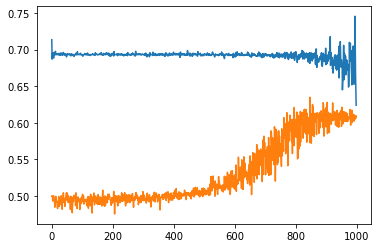

In [9]:
%matplotlib inline
plt.plot(losses)
plt.plot(acc_rates)
# plt.plot(pred_list-label_list)

In [10]:
torch.save(net.state_dict(), '%s/Epoch_%d.pth' % (checkpoint_path, this_Epoch+epoch_num))

In [11]:
x3 = adv_fea[length_of_dataset:]
x4 = clean_fea[length_of_dataset:]

X3_torch = torch.from_numpy(x3).float().to(device)
X4_torch = torch.from_numpy(x4).float().to(device)

Eval_torch = torch.cat((X3_torch, X4_torch), dim=0)
Eval_torch, _ = torch.sort(Eval_torch)
Eval_label = Y_torch

In [12]:
net.eval()
sample_size = 5000
with torch.no_grad():
    it_max = math.ceil(sample_size/batch_size)
    for it in range(it_max):
        # pick a random example id 
        j = it * batch_size
        # select the corresponding example and label
        if j+batch_size <= sample_size:
            example = Eval_torch[j:j+batch_size, :]
            label = Eval_label[j:j+batch_size]
        else:
            example = Eval_torch[j:, :]
            label = Eval_label[j:]
        
        # do a forward pass on the example
        pred = net(example)
        pred_top_1 = torch.argmax(pred, dim=1)
        Acc = (pred_top_1==label).sum().item()

print('Acc Rate :', Acc/sample_size)


Acc Rate : 0.0006
